# Demonstrate Local Or Remote Functions And Full Pipelines
  --------------------------------------------------------------------

Creating a local function, running predefined functions, creating and running a full ML pipeline with local and library functions.

#### **notebook how-to's**
* Create and test a simple function
* Examine data using serverless (containarized) `describe` function
* Create an automated ML pipeline from various library functions
* Running and tracking the pipeline results and artifacts

## Create and Test a Local Function (Iris Data Generator)
Import nuclio SDK and magics, <b>do not remove the cell and comment !!!</b>

In [1]:
# nuclio: ignore
import nuclio

#### Function code
Generate the iris dataset and log the dataframe (as csv or parquet file)

In [2]:
import os
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score
from mlrun.artifacts import TableArtifact, PlotArtifact
import pandas as pd

def iris_generator(context, format='csv'):
    iris = load_iris()
    iris_dataset = pd.DataFrame(data=iris.data, columns=iris.feature_names)
    iris_labels = pd.DataFrame(data=iris.target, columns=['label'])
    iris_dataset = pd.concat([iris_dataset, iris_labels], axis=1)
    
    context.logger.info('saving iris dataframe to {}'.format(context.artifact_path))
    context.log_dataset('iris_dataset', df=iris_dataset, format=format, index=False)


The following end-code annotation tells ```nuclio``` to stop parsing the notebook from this cell. _**Please do not remove this cell**_:

In [3]:
# nuclio: end-code
# marks the end of a code section

## Create a project to host our functions, jobs and artifacts

Projects are used to package multiple functions, workflows, and artifacts. We usually store project code and definitions in a Git archive.

The following code creates a new project in a local dir and initialize git tracking on that

In [4]:
from os import path
from mlrun import run_local, NewTask, mlconf, import_function, mount_v3io
mlconf.dbpath = mlconf.dbpath or 'http://mlrun-api:8080'

# specify artifacts target location
artifact_path = mlconf.artifact_path or path.abspath('./')
project_name = 'sk-project'

In [5]:
from mlrun import new_project, code_to_function
project_dir = './project'
skproj = new_project(project_name, project_dir, init_git=True)

<a id='test-locally'></a>
### Run the data generator function locally

The functions above can be tested locally. Parameters, inputs, and outputs can be specified in the API or the `Task` object.<br>
when using `run_local()` the function inputs and outputs are automatically recorded by MLRun experiment and data tracking DB.

In each run we can specify the function, inputs, parameters/hyper-parameters, etc... For more details, see the [mlrun_basics notebook](mlrun_basics.ipynb).

In [6]:
# run the function locally
gen = run_local(name='iris_gen', handler=iris_generator, 
                project=project_name, artifact_path=path.join(artifact_path, 'data'))


> 2021-09-29 10:45:02,816 [info] starting run iris_gen uid=7f800eb7f7dc49c590516d15026c0ef7 DB=http://mlrun-api:8080
> 2021-09-29 10:45:02,902 [info] saving iris dataframe to v3io:///projects/sk-project/artifacts/data


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
sk-project,...026c0ef7,0,Sep 29 10:45:02,completed,iris_gen,v3io_user=danikind=handlerowner=danihost=jupyter-dani-86575fbc89-k9xvr,,,,iris_dataset


> 2021-09-29 10:45:03,058 [info] run executed, status=completed


#### Convert our local code to a distributed serverless function object 

In [7]:
gen_func = code_to_function(name='gen_iris', kind='job')
gen_func.spec.build.commands = ['pip install sklearn', 'pip install pyarrow']
skproj.set_function(gen_func,image='mlrun/mlrun')

## Load and run a library function (visualize dataset features and stats)

<b>Step 1:</b> load the function object from the function hub (marketplace)<br>
> note: the function marketplace location is configurable, by default it points to `mlrun/functions` git


In [8]:
skproj.set_function('hub://describe', 'describe')

In [9]:
# read the remote function doc, params, usage
skproj.func('describe').doc()
#skproj.func('describe').spec.image_pull_policy = 'Always'

function: describe
describe and visualizes dataset stats
default handler: summarize
entry points:
  summarize: Summarize a table
    context(MLClientCtx)  - the function context, default=
    table(DataItem)  - MLRun input pointing to pandas dataframe (csv/parquet file path), default=
    label_column(str)  - ground truth column label, default=None
    class_labels(List[str])  - label for each class in tables and plots, default=[]
    plot_hist(bool)  - (True) set this to False for large tables, default=True
    plots_dest(str)  - destination folder of summary plots (relative to artifact_path), default=plots
    update_dataset  - when the table is a registered dataset update the charts in-place, default=False


<b>Step 2:</b> Run the describe function as a Kubernetes job with specified parameters.

> `mount_v3io()` vonnect our function to v3io shared file system and allow us to pass the data and get back the results (plots) directly to our notebook, we can choose other mount options to use NFS or object storage

In [10]:
skproj.func('describe').apply(mount_v3io()).run(params={'label_column': 'label'}, 
                                                inputs={"table": gen.outputs['iris_dataset']}, 
                                                artifact_path=artifact_path)

> 2021-09-29 10:45:07,516 [info] starting run describe-summarize uid=0ef5466782d34d41af618366be6a1d5e DB=http://mlrun-api:8080
> 2021-09-29 10:45:07,634 [info] Job is running in the background, pod: describe-summarize-b4nzc
> 2021-09-29 10:45:20,582 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
sk-project,...be6a1d5e,0,Sep 29 10:45:14,completed,describe-summarize,v3io_user=danikind=jobowner=danihost=describe-summarize-b4nzc,table,label_column=label,,histogramsviolinimbalanceimbalance-weights-veccorrelation-matrixcorrelation


> 2021-09-29 10:45:26,846 [info] run executed, status=completed


## Create a Fully Automated ML Pipeline

#### Add more functions to our project to be used in our pipeline (from the functions hub/marketplace)

AutoML training (classifier), Model validation (test_classifier), Real-time model server, and Model REST API Tester

In [11]:
skproj.set_function('hub://sklearn_classifier', 'train')
skproj.set_function('hub://test_classifier', 'test')
skproj.set_function('hub://model_server', 'serving')
skproj.set_function('hub://model_server_tester', 'live_tester')
#print(skproj.to_yaml())

#### Define and save a pipeline 

The following workflow definition will be written into a file, it describes a Kubeflow execution graph (DAG)<br>
and how functions and data are connected  to form an end to end pipeline. 

* Build the iris generator (ingest) function container 
* Ingest the iris data
* Analyze the dataset (describe)
* Train and test the model
* Deploy the model as a real-time serverless function
* Test the serverless function REST API with test dataset

Check the code below to see how functions objects are initialized and used (by name) inside the workflow.<br>
The `workflow.py` file has two parts, initialize the function objects and define pipeline dsl (connect the function inputs and outputs).

> Note: the pipeline can include CI steps like building container images and deploying models as illustrated  in the following example.


In [12]:
%%writefile project/workflow.py
from kfp import dsl
from mlrun import mount_v3io

funcs = {}
DATASET = 'iris_dataset'
LABELS  = "label"


# init functions is used to configure function resources and local settings
def init_functions(functions: dict, project=None, secrets=None):
    for f in functions.values():
        f.apply(mount_v3io())
     
    # uncomment this line to collect the inference results into a stream
    # and specify a path in V3IO (<datacontainer>/<subpath>)
    #functions['serving'].set_env('INFERENCE_STREAM', 'users/admin/model_stream')
    
@dsl.pipeline(
    name="Demo training pipeline",
    description="Shows how to use mlrun."
)
def kfpipeline():
    
    # build our ingestion function (container image)
    builder = funcs['gen-iris'].deploy_step(skip_deployed=True)
    
    # run the ingestion function with the new image and params
    ingest = funcs['gen-iris'].as_step(
        name="get-data",
        handler='iris_generator',
        image=builder.outputs['image'],
        params={'format': 'pq'},
        outputs=[DATASET])

    # analyze our dataset
    describe = funcs["describe"].as_step(
        name="summary",
        params={"label_column": LABELS},
        inputs={"table": ingest.outputs[DATASET]})
    
    # train with hyper-paremeters 
    train = funcs["train"].as_step(
        name="train-skrf",
        params={"sample"          : -1, 
                "label_column"    : LABELS,
                "test_size"       : 0.10},
        hyperparams={'model_pkg_class': ["sklearn.ensemble.RandomForestClassifier", 
                                         "sklearn.linear_model.LogisticRegression",
                                         "sklearn.ensemble.AdaBoostClassifier"]},
        selector='max.accuracy',
        inputs={"dataset"         : ingest.outputs[DATASET]},
        outputs=['model', 'test_set'])

    # test and visualize our model
    test = funcs["test"].as_step(
        name="test",
        params={"label_column": LABELS},
        inputs={"models_path" : train.outputs['model'],
                "test_set"    : train.outputs['test_set']})

    # deploy our model as a serverless function
    deploy = funcs["serving"].deploy_step(models={f"{DATASET}_v1": train.outputs['model']}, tag='v2')
    
    # test out new model server (via REST API calls)
    tester = funcs["live_tester"].as_step(name='model-tester',
        params={'addr': deploy.outputs['endpoint'], 'model': f"{DATASET}_v1"},
        inputs={'table': train.outputs['test_set']})


Overwriting project/workflow.py


In [13]:
# register the workflow file as "main", embed the workflow code into the project YAML
skproj.set_workflow('main', 'workflow.py', embed=True)

Save the project definitions to a file (project.yaml), it is recommended to commit all changes to a Git repo.

In [14]:
skproj.save()

<a id='run-pipeline'></a>
## Run a pipeline workflow
use the `run` method to execute a workflow, you can provide alternative arguments and specify the default target for workflow artifacts.<br>
The workflow ID is returned and can be used to track the progress or you can use the hyperlinks

> Note: The same command can be issued through CLI commands:<br>
    `mlrun project my-proj/ -r main -p "v3io:///users/admin/mlrun/kfp/{{workflow.uid}}/"`

The `dirty` flag allow us to run a project with uncommited changes (when the notebook is in the same git dir it will always be dirty)<br>
The `watch` flag will wait for the pipeline to complete and print results

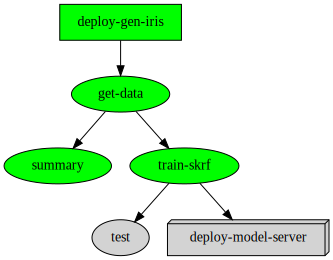

In [ ]:
artifact_path = path.abspath('./pipe/{{workflow.uid}}')
run_id = skproj.run(
    'main',
    arguments={}, 
    artifact_path=artifact_path, 
    dirty=True, watch=True)

**[back to top](#top)**